In [1]:
import csv
import os
import pickle
import sys
import copy

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append("../tools/")
# sys.path.append("../dataset/")
sys.path.append("../data_wrangling/")

from data_explorer import explorer
from feature_format import featureFormat, targetFeatureSplit

%matplotlib inline


<h2>Question 1</h2>

>Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those? [Relevant rubric items: “data exploration”, “outlier investigation”]


<h2>Setting up data for analysis</h2>

In [2]:
data_dict = {}
dataset = '../dataset/final_project_dataset.pkl'

#--- extract dictionary from dataset:
with open(dataset, 'rb') as data_file:
    data_dict = pickle.load(data_file)


<h3>Write dataset to csv file:</h3>

In [3]:
def convert_to_csv(data_dict, excluded_features = []):
    #--- Save dataset as CSV

    # Create ouput directory if it doesn't already exist:
    outdirname = '../output'
    try:
        os.makedirs(outdirname)
        print('\nDirectory "{}" created'.format(outdirname))
    except FileExistsError:
        print('\nDirectory "{}" already exists - nothing done.'.format(outdirname))

    csvfilename = outdirname + '/enron_data.csv'

    with open(csvfilename, 'w') as csv_file:
        print('\nWriting data set to ../{}'.format(csvfilename))
        writer = csv.writer(csv_file)

        #--- create header:
        header_line = ['Name']

        for name in data_dict.keys():
            if name != 'TOTAL':
                value_pairs = data_dict[name]

                for feature_value in value_pairs.keys():
                    if feature_value not in excluded_features:
                        header_line.append(feature_value)

                break

        writer.writerow(header_line)

        for name in data_dict.keys():
            line = []
            line.append(name)

            for k, v in data_dict[name].items():
                if k not in excluded_features:
                    line.append(v)

            writer.writerow(line)

In [4]:
convert_to_csv(data_dict)


Directory "../output" already exists - nothing done.

Writing data set to ../../output/enron_data.csv


<h2>Data Exploration</h2>
<h3>Summary of information contained in the dataset:</h3>

In [5]:

#--- explore data:
explore_obj = explorer(data_dict)

def repeat_to_length(string_to_expand, length):
    return (string_to_expand * (int(length/len(string_to_expand))+1))[:length]

parameters = explore_obj.get_dataset_parameters()
for k,v in parameters.items():
    if k != 'Features with NaN':
        l = 45 - len(k)
        dots = repeat_to_length('.', l)
        print('\t{0}: {1} {2}'.format(k, dots, v))


METTS MARK              0.0
BAXTER JOHN C           0.0
ELLIOTT STEVEN          0.0
CORDES WILLIAM R        0.0
HANNON KEVIN P          0.0
                       ... 
GRAMM WENDY L           0.0
CAUSEY RICHARD A        0.0
TAYLOR MITCHELL S       0.0
DONAHUE JR JEFFREY M    0.0
GLISAN JR BEN F         0.0
Length: 146, dtype: float64
	Number of individuals: ........................ 146
	Names: ........................................ ['METTS MARK', 'BAXTER JOHN C', 'ELLIOTT STEVEN', 'CORDES WILLIAM R', 'HANNON KEVIN P', 'MORDAUNT KRISTINA M', 'MEYER ROCKFORD G', 'MCMAHON JEFFREY', 'HAEDICKE MARK E', 'PIPER GREGORY F', 'HUMPHREY GENE E', 'NOLES JAMES L', 'BLACHMAN JEREMY M', 'SUNDE MARTIN', 'GIBBS DANA R', 'LOWRY CHARLES P', 'COLWELL WESLEY', 'MULLER MARK S', 'JACKSON CHARLENE R', 'WESTFAHL RICHARD K', 'WALTERS GARETH W', 'WALLS JR ROBERT H', 'KITCHEN LOUISE', 'CHAN RONNIE', 'BELFER ROBERT', 'SHANKMAN JEFFREY A', 'WODRASKA JOHN', 'BERGSIEKER RICHARD P', 'URQUHART JOHN A', 'BIBI PHILIPPE

<h3>Dataset statistical information:</h3>

In [6]:
# Create dataframe from Enron data_dict:
enron_df = explore_obj.get_dataframe()
enron_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, METTS MARK to GLISAN JR BEN F
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   salary                     95 non-null     float64
 1   to_messages                86 non-null     float64
 2   deferral_payments          39 non-null     float64
 3   total_payments             125 non-null    float64
 4   loan_advances              4 non-null      float64
 5   bonus                      82 non-null     float64
 6   email_address              111 non-null    object 
 7   restricted_stock_deferred  18 non-null     float64
 8   deferred_income            49 non-null     float64
 9   total_stock_value          126 non-null    float64
 10  expenses                   95 non-null     float64
 11  from_poi_to_this_person    86 non-null     float64
 12  exercised_stock_options    102 non-null    float64
 13  from_messages              86 non-

In [7]:
for cond in [True, False]:
    if cond == True:
        print('\nStatistical information for POIs in dataset:')
        display((enron_df.loc[enron_df['poi'] == cond]).describe())
    else:
        print('\nStatistical information for non-POIs in dataset:')
        display((enron_df.loc[enron_df['poi'] == cond]).describe())
    


Statistical information for POIs in dataset:


,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
count,1.700000e+01,14.000000,5.000000e+00,1.800000e+01,1.0,1.600000e+01,0.0,1.100000e+01,1.800000e+01,18.000000,14.000000,1.200000e+01,14.000000,1.800000e+01,14.000000,1.200000e+01,14.000000,1.700000e+01,0.0
mean,3.834449e+05,2417.142857,5.198942e+05,7.913590e+06,81525000.0,2.075000e+06,NaN,-1.035313e+06,9.165671e+06,59873.833333,97.785714,1.046379e+07,300.357143,8.029974e+05,66.714286,1.204862e+06,1783.000000,2.318621e+06,NaN
std,2.783597e+05,1961.858101,9.128895e+05,2.396549e+07,NaN,2.047437e+06,NaN,1.334972e+06,1.384117e+07,37524.658812,76.058862,1.238259e+07,805.844574,2.417568e+06,158.289622,9.916583e+05,1264.996625,3.620811e+06,NaN
min,1.584030e+05,225.000000,1.025900e+04,9.109300e+04,81525000.0,2.000000e+05,NaN,-3.504386e+06,1.260270e+05,16514.000000,13.000000,3.847280e+05,16.000000,4.860000e+02,4.000000,7.102300e+04,91.000000,1.260270e+05,NaN
25%,2.401890e+05,1115.750000,2.761000e+04,1.142396e+06,81525000.0,7.750000e+05,NaN,-1.860244e+06,1.016450e+06,31323.250000,44.500000,1.456581e+06,33.000000,4.979500e+03,12.500000,3.689780e+05,1059.250000,3.938180e+05,NaN
50%,2.786010e+05,1875.000000,2.029110e+05,1.754028e+06,81525000.0,1.275000e+06,NaN,-2.625000e+05,2.206836e+06,50448.500000,62.000000,3.914557e+06,44.500000,1.492040e+05,15.500000,1.134637e+06,1589.000000,9.850320e+05,NaN
75%,4.151890e+05,2969.250000,2.146780e+05,2.665345e+06,81525000.0,2.062500e+06,NaN,-1.220310e+05,1.051133e+07,84125.000000,135.750000,1.938604e+07,101.500000,2.607725e+05,28.750000,1.646772e+06,2165.250000,2.502063e+06,NaN
max,1.111258e+06,7991.000000,2.144013e+06,1.035598e+08,81525000.0,7.000000e+06,NaN,-8.330000e+02,4.911008e+07,127017.000000,240.000000,3.434838e+07,3069.000000,1.035973e+07,609.000000,3.600000e+06,5521.000000,1.476169e+07,NaN



Statistical information for non-POIs in dataset:


,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
count,7.800000e+01,72.000000,3.400000e+01,1.070000e+02,3.000000e+00,6.600000e+01,1.800000e+01,3.800000e+01,1.080000e+02,7.700000e+01,72.000000,9.000000e+01,72.000000,7.500000e+01,72.000000,5.400000e+01,72.000000,9.300000e+01,1.700000e+01
mean,6.011525e+05,2007.111111,1.807789e+06,4.605105e+06,2.877500e+07,2.446776e+06,1.664106e+05,-1.170917e+06,6.375339e+06,1.201496e+05,58.500000,5.390155e+06,668.763889,9.469212e+05,36.277778,1.529361e+06,1058.527778,2.322312e+06,1.668049e+05
std,2.997169e+06,2693.165955,5.510228e+06,2.990485e+07,4.776800e+07,1.191776e+07,4.201494e+06,4.531597e+06,4.173084e+07,5.925085e+05,87.995198,3.275556e+07,1978.997801,4.983723e+06,85.139690,6.564217e+06,1132.503757,1.354194e+07,3.198914e+05
min,4.770000e+02,57.000000,-1.025000e+05,1.480000e+02,4.000000e+05,7.000000e+04,-7.576788e+06,-2.799289e+07,-4.409300e+04,1.480000e+02,0.000000,3.285000e+03,12.000000,2.000000e+00,0.000000,6.922300e+04,2.000000,-2.604490e+06,3.285000e+03
25%,2.072158e+05,513.750000,8.746875e+04,3.410185e+05,1.200000e+06,4.000000e+05,-3.896218e+05,-5.812438e+05,4.282172e+05,1.883400e+04,10.000000,4.507585e+05,20.500000,9.595000e+02,0.000000,2.608932e+05,191.500000,2.130630e+05,9.878400e+04
50%,2.545700e+05,944.000000,3.825325e+05,1.057548e+06,2.000000e+06,7.250000e+05,-1.469750e+05,-1.231420e+05,1.032338e+06,4.614500e+04,26.500000,1.043324e+06,41.000000,2.555300e+04,6.000000,3.954805e+05,594.000000,4.176190e+05,1.085790e+05
75%,3.002298e+05,2590.750000,1.066354e+06,2.031214e+06,4.296250e+07,1.000000e+06,-7.500975e+04,-3.708600e+04,2.372703e+06,7.855200e+04,61.750000,2.204999e+06,216.500000,3.876305e+05,23.250000,6.948620e+05,1635.500000,9.340650e+05,1.137840e+05
max,2.670423e+07,15149.000000,3.208340e+07,3.098866e+08,8.392500e+07,9.734362e+07,1.545629e+07,-1.042000e+03,4.345095e+08,5.235198e+06,528.000000,3.117640e+08,14368.000000,4.266759e+07,411.000000,4.852193e+07,4527.000000,1.303223e+08,1.398517e+06


In [8]:
(enron_df.loc[enron_df['poi'] == False]).describe()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
count,7.800000e+01,72.000000,3.400000e+01,1.070000e+02,3.000000e+00,6.600000e+01,1.800000e+01,3.800000e+01,1.080000e+02,7.700000e+01,72.000000,9.000000e+01,72.000000,7.500000e+01,72.000000,5.400000e+01,72.000000,9.300000e+01,1.700000e+01
mean,6.011525e+05,2007.111111,1.807789e+06,4.605105e+06,2.877500e+07,2.446776e+06,1.664106e+05,-1.170917e+06,6.375339e+06,1.201496e+05,58.500000,5.390155e+06,668.763889,9.469212e+05,36.277778,1.529361e+06,1058.527778,2.322312e+06,1.668049e+05
std,2.997169e+06,2693.165955,5.510228e+06,2.990485e+07,4.776800e+07,1.191776e+07,4.201494e+06,4.531597e+06,4.173084e+07,5.925085e+05,87.995198,3.275556e+07,1978.997801,4.983723e+06,85.139690,6.564217e+06,1132.503757,1.354194e+07,3.198914e+05
min,4.770000e+02,57.000000,-1.025000e+05,1.480000e+02,4.000000e+05,7.000000e+04,-7.576788e+06,-2.799289e+07,-4.409300e+04,1.480000e+02,0.000000,3.285000e+03,12.000000,2.000000e+00,0.000000,6.922300e+04,2.000000,-2.604490e+06,3.285000e+03
25%,2.072158e+05,513.750000,8.746875e+04,3.410185e+05,1.200000e+06,4.000000e+05,-3.896218e+05,-5.812438e+05,4.282172e+05,1.883400e+04,10.000000,4.507585e+05,20.500000,9.595000e+02,0.000000,2.608932e+05,191.500000,2.130630e+05,9.878400e+04
50%,2.545700e+05,944.000000,3.825325e+05,1.057548e+06,2.000000e+06,7.250000e+05,-1.469750e+05,-1.231420e+05,1.032338e+06,4.614500e+04,26.500000,1.043324e+06,41.000000,2.555300e+04,6.000000,3.954805e+05,594.000000,4.176190e+05,1.085790e+05
75%,3.002298e+05,2590.750000,1.066354e+06,2.031214e+06,4.296250e+07,1.000000e+06,-7.500975e+04,-3.708600e+04,2.372703e+06,7.855200e+04,61.750000,2.204999e+06,216.500000,3.876305e+05,23.250000,6.948620e+05,1635.500000,9.340650e+05,1.137840e+05
max,2.670423e+07,15149.000000,3.208340e+07,3.098866e+08,8.392500e+07,9.734362e+07,1.545629e+07,-1.042000e+03,4.345095e+08,5.235198e+06,528.000000,3.117640e+08,14368.000000,4.266759e+07,411.000000,4.852193e+07,4527.000000,1.303223e+08,1.398517e+06


<h3>Example of data content for POI Kenneth Lay:</h3>

In [9]:
sample_contents = data_dict['LAY KENNETH L']
for k, v in sample_contents.items():
    l = 45 - len(k)
    dots = repeat_to_length('.', l)
    print('\t{0}: {1} {2}'.format(k, dots, v))

	salary: ....................................... 1072321
	to_messages: .................................. 4273
	deferral_payments: ............................ 202911
	total_payments: ............................... 103559793
	loan_advances: ................................ 81525000
	bonus: ........................................ 7000000
	email_address: ................................ kenneth.lay@enron.com
	restricted_stock_deferred: .................... NaN
	deferred_income: .............................. -300000
	total_stock_value: ............................ 49110078
	expenses: ..................................... 99832
	from_poi_to_this_person: ...................... 123
	exercised_stock_options: ...................... 34348384
	from_messages: ................................ 36
	other: ........................................ 10359729
	from_this_person_to_poi: ...................... 16
	poi: .......................................... True
	long_term_incentive: ................

<h3>Ratio of NaN entries per feature in dataset:</h3>

<h4>Short Definition of Financial Terms</h4>

><b>total_payments</b>: <i>Total payment is any payment or benefit received or to be received by the Executive in connection with a Change in Control or the termination of the Executive's employment.</i>[source: https://www.lawinsider.com/]

><b>loan_advances</b>: <i>Loan Advance means a disbursement of all or any portion of the Loan.</i>[source: https://www.lawinsider.com/]

><b>deferred_income</b>: <i>Deferred income (also known as deferred revenue, unearned revenue, or unearned income) is, in accrual accounting, money received for goods or services which has not yet been earned. According to the revenue recognition principle, it is recorded as a liability until delivery is made, at which time it is converted into revenue.</i>[source: https://en.wikipedia.org/wiki/Deferred_income]

><b>bonus</b>: <i>A bonus payment is usually made to employees in addition to their base salary as part of their wages or salary. While the base salary usually is a fixed amount per month, bonus payments more often than not vary depending on known criteria, such as the annual turnover, or the net number of additional customers acquired, or the current value of the stock of a public company.</i>[source: https://en.wikipedia.org/wiki/Bonus_payment]

><b>restricted_stock_deferred</b>: <i>Restricted stocks have specified limits with regard to the ability of the employee to monetize or access the stocks. While both deferred and restricted stocks may be subject to vesting requirements, resulting in a delay before the employee takes full ownership of the associated shares, restricted stocks are immediately converted to unrestricted shares once the period has ended, while deferred shares do not convert until a selected date beyond the vesting date.</i>[source: https://www.investopedia.com/terms/d/deferredshare.asp]

><b>exercised_stock_options</b>: <i>RExercising a stock option means purchasing the issuer's common stock at the price set by the option (grant price), regardless of the stock's price at the time you exercise the option.</i>[source: https://www.fidelity.com/products/stockoptions/exercise.shtml]

><b>long_term_incentive</b>: <i>A long-term incentive plan (LTIP) is a company policy that rewards employees for reaching specific goals that lead to increased shareholder value.</i>[source: https://www.investopedia.com/terms/l/long_term_incentive-plan.asp]

In [10]:
features_nan_counts = explore_obj.get_feature_nan_counts()
df_features_nan_counts = pd.DataFrame(features_nan_counts.items())
df_features_nan_counts.columns = ['Feature','NaN count']
df_features_nan_counts.sort_values(by=['NaN count'], inplace=True)
df_features_nan_counts.reset_index(drop=True, inplace=True)

max_nan_count = df_features_nan_counts.iloc[len(df_features_nan_counts)-1]['NaN count']
print('\nMax NaN count: {}'.format(max_nan_count))
df_features_nan_counts['ratio'] = df_features_nan_counts['NaN count']/max_nan_count
print(df_features_nan_counts.to_string(index=False))

#--- list features with more than selected percentage (%) NaNs:
thresh_ratio = 0.7
rslt_df = df_features_nan_counts.loc[df_features_nan_counts['ratio'] > thresh_ratio]
nan_features = rslt_df['Feature'].tolist()
print('\nFeatures with NaN > {} % will be excluded:'.format(thresh_ratio*100.0))
print(nan_features)

selected_features = []
all_features = explore_obj.get_features()

for feature in all_features:
    if feature not in nan_features:
        selected_features.append(feature)

print('\nselected features:\n{}'.format(selected_features))


Max NaN count: 142
                  Feature  NaN count    ratio
                     Name          0 0.000000
                      poi          0 0.000000
        total_stock_value         20 0.140845
           total_payments         21 0.147887
            email_address         35 0.246479
         restricted_stock         36 0.253521
  exercised_stock_options         44 0.309859
                   salary         51 0.359155
                 expenses         51 0.359155
                    other         53 0.373239
  from_poi_to_this_person         60 0.422535
            from_messages         60 0.422535
  from_this_person_to_poi         60 0.422535
  shared_receipt_with_poi         60 0.422535
              to_messages         60 0.422535
                    bonus         64 0.450704
      long_term_incentive         80 0.563380
          deferred_income         97 0.683099
        deferral_payments        107 0.753521
restricted_stock_deferred        128 0.901408
            di

<h3>NaN entries per employee in dataset:</h3>

In [11]:
df_employee_nan_counts = ((enron_df[all_features].isna()).sum(axis=1)).to_frame()
df_employee_nan_counts['Name'] = df_employee_nan_counts.index
df_employee_nan_counts.columns = ['NaN count', 'Name']
df_employee_nan_counts = df_employee_nan_counts[['Name', 'NaN count']]
df_employee_nan_counts['NaN %'] = (df_employee_nan_counts['NaN count'] / len(all_features))*100.
df_employee_nan_counts.sort_values(by=['NaN count'], inplace=True)
df_employee_nan_counts.reset_index(drop=True, inplace=True)
df_employee_nan_counts

,Name,NaN count,NaN %
0,LAY KENNETH L,2,9.090909
1,FREVERT MARK A,2,9.090909
2,HAEDICKE MARK E,2,9.090909
3,ALLEN PHILLIP K,2,9.090909
4,DERRICK JR. JAMES V,3,13.636364
...,...,...,...
141,WROBEL BRUCE,18,81.818182
142,WHALEY DAVID A,18,81.818182
143,GRAMM WENDY L,18,81.818182
144,THE TRAVEL AGENCY IN THE PARK,18,81.818182


In [12]:
#--- Remove employees with NaN count > 90%
empl_to_pop = df_employee_nan_counts.loc[df_employee_nan_counts['NaN %'] >90. , 'Name'].tolist()

size_empl_to_pop = len(empl_to_pop)

if size_empl_to_pop > 1:
    print('\nThe following employees have more than 90% NaN entries and will be ignored if non-POI:')
    print(empl_to_pop)
elif size_empl_to_pop == 1:
    print('\nThe following employee has more than 90% NaN entries and will be ignored if non-POI:')
    print(empl_to_pop[0])
else:
    pass

poi_list = explore_obj.get_poi_list()

for empl in empl_to_pop:
    if empl not in poi_list:
        data_dict.pop(empl, 0)

#--- remove 'TOTAL' point:
print('\nAlso "TOTAL" entry removed from data_dict')
data_dict.pop('TOTAL', 0) 



The following employee has more than 90% NaN entries and will be ignored if non-POI:
LOCKHART EUGENE E

Also "TOTAL" entry removed from data_dict


{'salary': 26704229,
 'to_messages': 'NaN',
 'deferral_payments': 32083396,
 'total_payments': 309886585,
 'loan_advances': 83925000,
 'bonus': 97343619,
 'email_address': 'NaN',
 'restricted_stock_deferred': -7576788,
 'deferred_income': -27992891,
 'total_stock_value': 434509511,
 'expenses': 5235198,
 'from_poi_to_this_person': 'NaN',
 'exercised_stock_options': 311764000,
 'from_messages': 'NaN',
 'other': 42667589,
 'from_this_person_to_poi': 'NaN',
 'poi': False,
 'long_term_incentive': 48521928,
 'shared_receipt_with_poi': 'NaN',
 'restricted_stock': 130322299,
 'director_fees': 1398517}

In [13]:
#--- Remove features with NaN above threshhold from the dataset:

def clean_features(dict, features_to_exclude):
    clean_dict = {}
    
    for k, v in dict.items():
        value_pair = v

        inner_dict = {}
        for k1, v1 in value_pair.items():
            if k1 not in features_to_exclude:
                inner_dict[k1] = v1

        clean_dict[k] = copy.deepcopy(inner_dict)

    return clean_dict

data_dict = clean_features(data_dict, nan_features)

In [14]:
sample_contents = data_dict['BHATNAGAR SANJAY']
for k, v in sample_contents.items():
    l = 45 - len(k)
    dots = repeat_to_length('.', l)
    print('\t{0}: {1} {2}'.format(k, dots, v))

	salary: ....................................... NaN
	to_messages: .................................. 523
	total_stock_value: ............................ NaN
	total_payments: ............................... 15456290
	bonus: ........................................ NaN
	email_address: ................................ sanjay.bhatnagar@enron.com
	deferred_income: .............................. NaN
	expenses: ..................................... NaN
	from_poi_to_this_person: ...................... 0
	exercised_stock_options: ...................... 2604490
	from_messages: ................................ 29
	other: ........................................ 137864
	from_this_person_to_poi: ...................... 1
	poi: .......................................... False
	long_term_incentive: .......................... NaN
	shared_receipt_with_poi: ...................... 463
	restricted_stock: ............................. -2604490


In [15]:
enron_df = (pd.DataFrame.from_dict(data_dict)).T
enron_df.replace('NaN', np.nan, inplace=True)
# enron_df


In [16]:
#--- Ref.: https://www.shanelynn.ie/pandas-iloc-loc-select-rows-and-columns-dataframe/
#enron_df.loc['BHATNAGAR SANJAY']

In [17]:
#--- create dataframe from updated dictionary dataset:
convert_to_csv(data_dict)


Directory "../output" already exists - nothing done.

Writing data set to ../../output/enron_data.csv


In [18]:
#--- further explore the new dataset by looking into each feature:

#--- Money related features:
financial_features = ['salary', 'total_payments', 'bonus', 'deferred_income', 'total_stock_value', 
    'expenses', 'exercised_stock_options', 'long_term_incentive', 'restricted_stock']

#--- Email related features:
email_features = ['from_poi_to_this_person','from_this_person_to_poi','from_messages',
    'shared_receipt_with_poi','to_messages']


In [19]:
def sns_boxplot(df, title, features, n, m):
    '''
    Create grid boxplot
    - df = dataframe
    - title = plot title
    - features = list of features to consider
    - n = number of rows for grid plot
    - m = number of columns for grid plot
    '''
    #--- Ref: https://www.geeksforgeeks.org/multi-plot-grid-in-seaborn/
    # n = 2
    # m = 3

    fig, axes = plt.subplots(n, m, figsize=(24, 10))
    fig.suptitle(title)

    k = 0
    for i in range(n):
        for j in range(m):
            feature = features[k]
            (pd.to_numeric(df[feature]).groupby(df['poi'])).mean()
            sns.boxplot(ax=axes[i, j], data=df, x='poi', y=feature)
            if (k+1) < len(features):
                k+=1
            else:
                break

<h3>Explore Enron Employee Financial Data</h3>

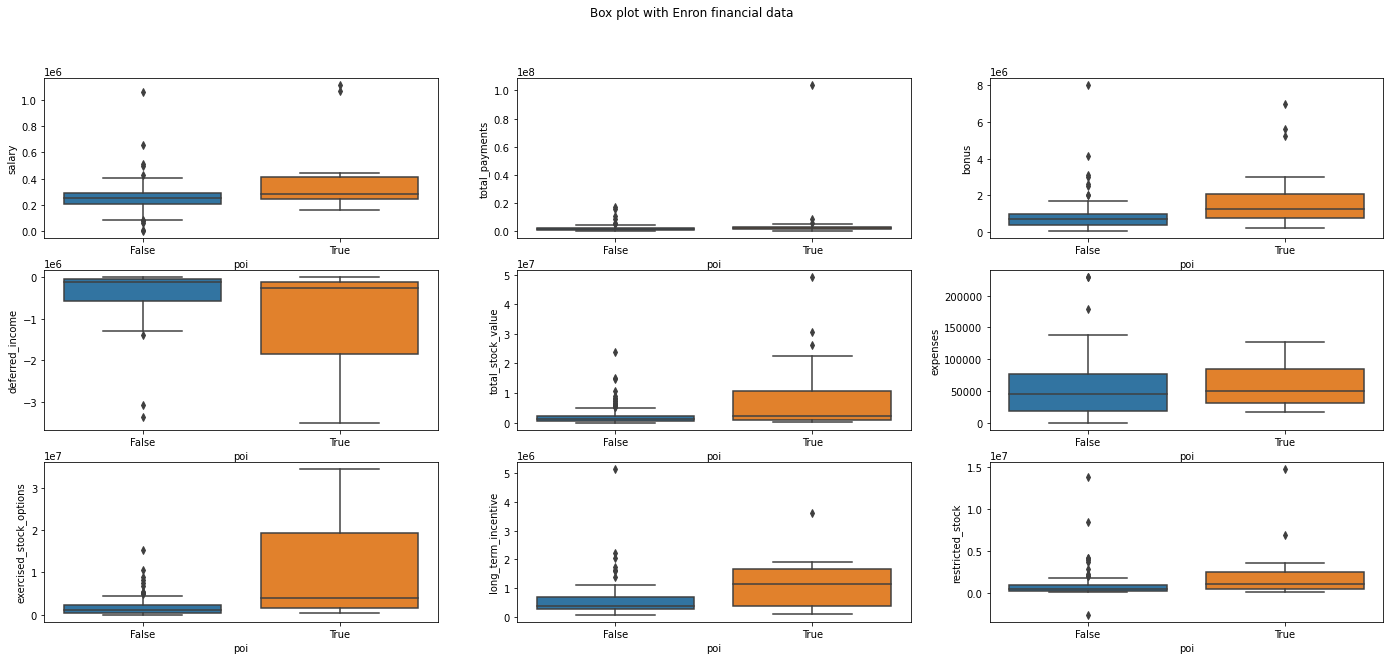

In [20]:

sns_boxplot(enron_df, 'Box plot with Enron financial data', financial_features, 3, 3)

<h3>Explore Enron Employee Email Data</h3>

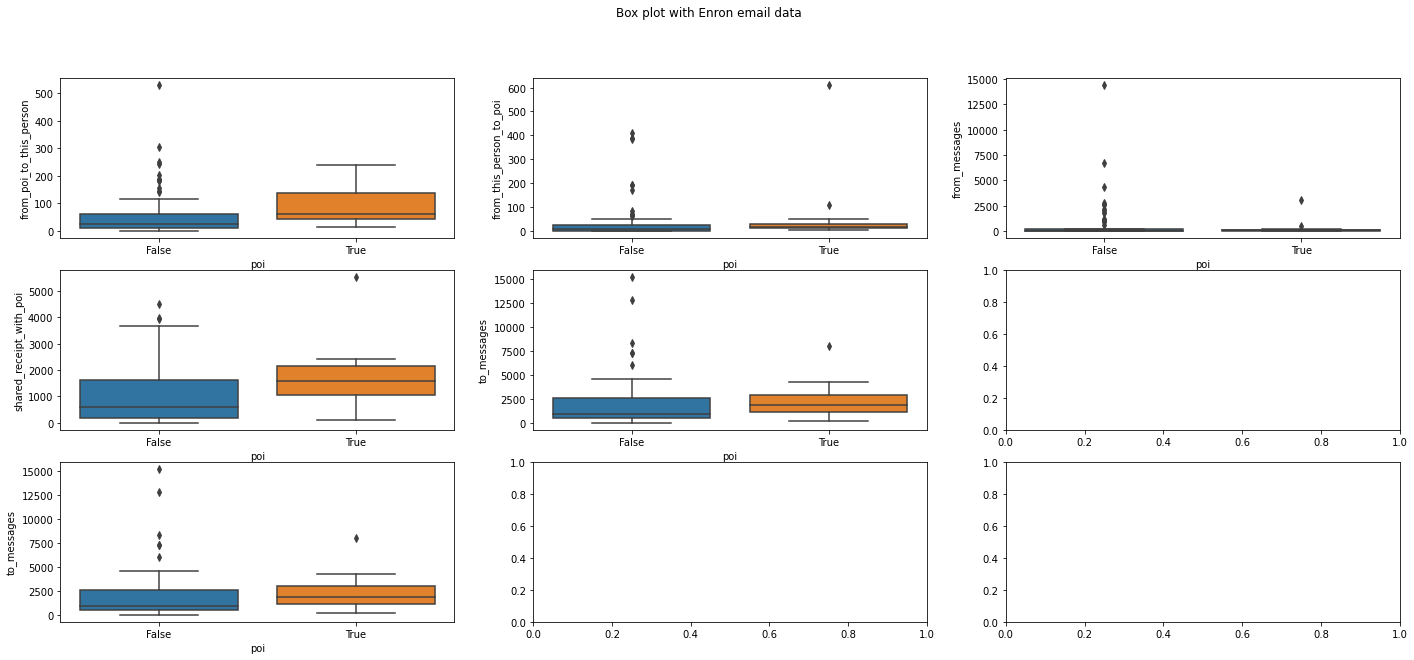

In [21]:
#--- Explore email features:

#--- Compare POI data vs non-POI data:
sns_boxplot(enron_df, 'Box plot with Enron email data', email_features, 3, 3)


C:\Users\danza\anaconda3\envs\nano_p4\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


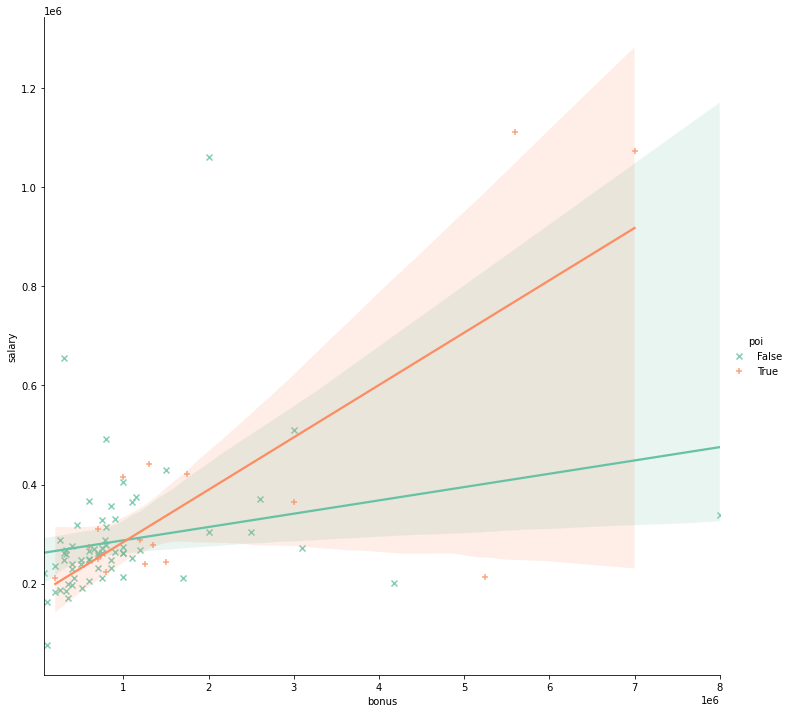

In [22]:
sns.lmplot(x='bonus', y= 'salary', hue='poi', data=enron_df, palette='Set2',size=10,markers=['x','+'])

C:\Users\danza\anaconda3\envs\nano_p4\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


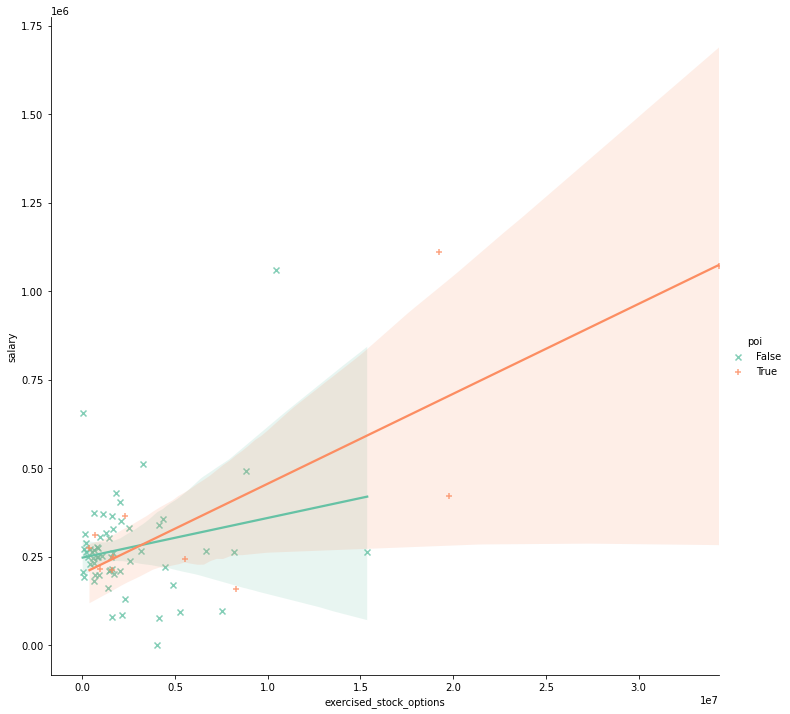

In [23]:
sns.lmplot(x='exercised_stock_options', y= 'salary', hue='poi', data=enron_df, palette='Set2',size=10,markers=['x','+'])

<h2>Question 2</h2>

>
# from_poi_to_this_person_ratio and from_this_person_to_poi_ratio
def computeRatio(messages, allMessages):
    ratio = 0.
    if (messages == 'NaN' or allMessages == 'NaN'):
        return ratio
    ratio = messages / float(allMessages)
    return ratio ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importance of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values. [relevant rubric items: “create new features”, “intelligently select features”, “properly scale features”]

In [28]:
#--cover

# from_poi_to_this_person_ratio and from_this_person_to_poi_ratio
def computeRatio(messages, allMessages):
    ratio = 0.
    if (messages == 'NaN' or allMessages == 'NaN'):
        return ratio
    ratio = messages / float(allMessages)
    return ratio

def createNewFeatures(my_dataset):
    for poi_name in my_dataset:
        data_point = my_dataset[poi_name]
        data_point['from_poi_to_this_person_ratio'] = computeRatio(data_point['from_poi_to_this_person'],
                                                                   data_point['to_messages'])
        data_point['from_this_person_to_poi_ratio'] = computeRatio(data_point['from_this_person_to_poi'],
                                                                   data_point['from_messages'])
    return my_dataset, ['from_poi_to_this_person_ratio', 'from_this_person_to_poi_ratio']

In [29]:
#--cover
# 
# #--- create and add new features
dataset, new_features = createNewFeatures(data_dict)
selected_features = financial_features + email_features + new_features
print(selected_features)

['salary', 'total_payments', 'bonus', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'long_term_incentive', 'restricted_stock', 'from_poi_to_this_person', 'from_this_person_to_poi', 'from_messages', 'shared_receipt_with_poi', 'to_messages', 'from_poi_to_this_person_ratio', 'from_this_person_to_poi_ratio']


In [33]:
#--- cover

### Select what features to use
first_list = ['poi','total_millions','fraction_to_poi','from_messages']
second_list = ['poi','total_be','fraction_to_poi','from_messages']
third_list = ['poi','salary','bonus','fraction_to_poi','from_messages']
fourth_list = ['poi','bonus','exercised_stock_options','fraction_to_poi']

features_final_list = fourth_list
print("Final List", features_final_list)

Final List ['poi', 'bonus', 'exercised_stock_options', 'fraction_to_poi']


In [60]:
#--cover

#Evaluation metrics

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import scikitplot as skplt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

#Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# %load 'my_test.py'
def test_list(classifier, feature_list, enron_dict):
    
    my_dataset = enron_dict
    
    data = featureFormat(my_dataset, feature_list, sort_keys = True) 
    labels, features = targetFeatureSplit(data) 
    
    X = np.array(features)
    y = np.array(labels)

    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=42)

   # sss.get_n_splits(X, y)

    # for train_index, test_index in sss.split(X, y):
    #     features_train, features_test = X[train_index], X[test_index]
    #     labels_train, labels_test = y[train_index], y[test_index]
    
    features_train, features_test, labels_train, labels_test = train_test_split(X, y, test_size=0.33, random_state=42)

    clf = classifier
    clf.fit(features_train,labels_train)
    pred = clf.predict(features_test)
    
    if classifier == DecisionTreeClassifier():
        return {'Accuracy': accuracy_score(labels_test,pred),'Precision': precision_score(labels_test,pred),
                'Recall': recall_score(labels_test,pred), 'Feature Importance': clf.feature_importances_}
    
    return {'Accuracy': accuracy_score(labels_test,pred),'Precision': precision_score(labels_test,pred),
            'Recall': recall_score(labels_test,pred)}
    


In [61]:
#--cover

#full list
print(selected_features)
print('GaussianNB: ', test_list(GaussianNB(), selected_features, data_dict))
print('DecisionTree: ', test_list(DecisionTreeClassifier(),selected_features,data_dict))
print('KNeighbors: ', test_list(KNeighborsClassifier(),selected_features,data_dict))


['salary', 'total_payments', 'bonus', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'long_term_incentive', 'restricted_stock', 'from_poi_to_this_person', 'from_this_person_to_poi', 'from_messages', 'shared_receipt_with_poi', 'to_messages', 'from_poi_to_this_person_ratio', 'from_this_person_to_poi_ratio']


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

<h2>Question 3</h2>

>What algorithm did you end up using? What other one(s) did you try? How did model
performance differ between algorithms? [relevant rubric item: “pick an algorithm”]

<h2>Question 4</h2>

>What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well? How did you tune the parameters of your particular algorithm? What parameters did you tune? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier). [relevant rubric items: “discuss parameter tuning”, “tune the algorithm”]

<h2>Question 5</h2>

>What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis? [relevant rubric items: “discuss validation”, “validation strategy”]

<h2>Question 6</h2>

>Give at least 2 evaluation metrics and your average performance for each of them.
Explain an interpretation of your metrics that says something human-understandable
about your algorithm’s performance. [relevant rubric item: “usage of evaluation metrics”]